In [22]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

### Read the root directory of images and extract pixel features and flatten into a 1d vector

In [23]:
dataset_path = 'Lab 2 Data' 
features = []
labels = []

# Loop over each subject folder
for subject_folder in sorted(os.listdir(dataset_path)):
    if subject_folder.startswith('s'):
        subject_number = int(subject_folder[1:])  
        subject_path = os.path.join(dataset_path, subject_folder)

        # Loop over each image in the subject folder
        for image_file in sorted(os.listdir(subject_path)):
            if image_file.endswith('.pgm'):
                image_path = os.path.join(subject_path, image_file)
                
                # Load the image
                img = Image.open(image_path)
                img_array = np.array(img)
                
                # Flatten the image to 1D vector
                flattened_vector = img_array.flatten()

                # Append data and label
                features.append(flattened_vector)
                labels.append(subject_number)

features = np.array(features)
labels = np.array(labels)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)      

Features shape: (400, 10304)
Labels shape: (400,)


### Sample images for subjects

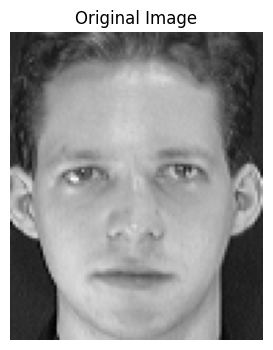

In [24]:
img  = features[0]
original = features[0].reshape(112,92)  # Assuming ORL face dataset shape
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original, cmap='gray')
plt.axis('off')

plt.show()

### Split Data into Odd indexed rows for training and even indexed for testing

In [25]:
X_train = features[::2]
X_test  = features[1::2] 
y_train = labels[::2]
y_test  = labels[1::2]

### PCA Implementation
Principal Component Analysis (PCA) is a powerful dimensionality reduction technique.
The goal of PCA is:
. To find new axes (called principal components) that capture the most variance in the data.
. Reduce data to fewer dimensions while preserving as much information as possible.
. Remove redundancy (correlated features) by rotating the data into a new orthogonal basis.

#### Approach:
Given a dataset 𝑋 with n samples and d features:

1. Center the Data
Subtract the mean from each feature so that each feature has mean = 0.

2. Compute Covariance Matrix
Calculate how features vary together (covariances).

3. Eigen-Decomposition
Solve for eigenvalues and eigenvectors of the covariance matrix.
Eigenvectors = principal directions (new axes)
Eigenvalues = amount of variance captured by each eigenvector.

4. Sort Eigenvectors
Sort by eigenvalues (highest first).
First eigenvector captures the most variance.
Second eigenvector is orthogonal and captures next most variance, etc.

5. Select Top k Components
Choose the top 𝑘 eigenvectors to preserve a desired amount of variance (e.g., 95%).

6. Project Data
Transform data into the space of top k eigenvectors (lower dimensions).

In [26]:
class PCA:
    def __init__(self, alpha=0.95):
        self.alpha = alpha
        self.cov_matrix = None
        self.eigen_vals = None
        self.eigen_vecs = None
        self.k = None
        self.top_k_vecs = None
        self.mu = None

    def _calculate_covariance(self, X):
        # Compute mean and center data
        self.mu = np.mean(X, axis=0)
        X_centered = X - self.mu
        # Use unbiased estimator: divide by n-1
        cov = (1.0 / (X_centered.shape[0] - 1)) * (X_centered.T @ X_centered)
        return cov

    def fit(self, X, boolean):
        # Fit PCA: compute covariance, eigen decomposition, sort, and save
        self.cov_matrix = self._calculate_covariance(X)
        self.eigen_vals, self.eigen_vecs = np.linalg.eigh(self.cov_matrix)

        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(self.eigen_vals)[::-1]
        self.eigen_vals = self.eigen_vals[idx]
        self.eigen_vecs = self.eigen_vecs[:, idx]
        if(boolean == 1):
            # Save for later use
            np.save(f'eigen_vals_train.npy',self.eigen_vals)
            np.save(f'eigen_vecs_train.npy',self.eigen_vecs)
            np.save(f'means_vector_train.npy',self.mu)
        else:
            np.save(f'eigen_vals_test.npy',self.eigen_vals)
            np.save(f'eigen_vecs_test.npy',self.eigen_vecs)
            np.save(f'means_vector_test.npy',self.mu)
        
        self.set_alpha(self.alpha)

    def load_eigen(self,data):
        # Load precomputed eigenvalues, eigenvectors, and mean
        self.eigen_vals = np.load(f'eigen_vals_{data}.npy')
        self.eigen_vecs = np.load(f'eigen_vecs_{data}.npy')
        self.mu = np.load(f'means_vector_{data}.npy')
        
    def set_alpha(self, alpha):
        self.alpha = alpha
        cum_var = np.cumsum(self.eigen_vals)
        total = cum_var[-1]
        ratio = cum_var / total
        self.k = np.searchsorted(ratio, self.alpha, side='right') + 1
        self.k = min(self.k, len(self.eigen_vals))  # Prevent index out of bounds
        self.top_k_vecs = self.eigen_vecs[:, :self.k]


    def transform(self, X):
        if self.mu is None or self.top_k_vecs is None:
            raise ValueError("PCA not fitted. Call .fit() or .load_eigen() first.")
        X_centered = X - self.mu
        return X_centered @ self.top_k_vecs

    def fit_transform(self, X):
        self.fit(X)
        self.set_alpha(self.alpha)
        return self.transform(X)

    def inverse_transform(self, Z):
        self.set_alpha(self.alpha)
        return (Z @ self.top_k_vecs.T) + self.mu




In [27]:
pca = PCA()
pca.fit(X_train,1)
pca.fit(X_test,0)

### Try dimensionality reduction on diiferent values of alpha

Retained dimensions: 44 (out of 10304)


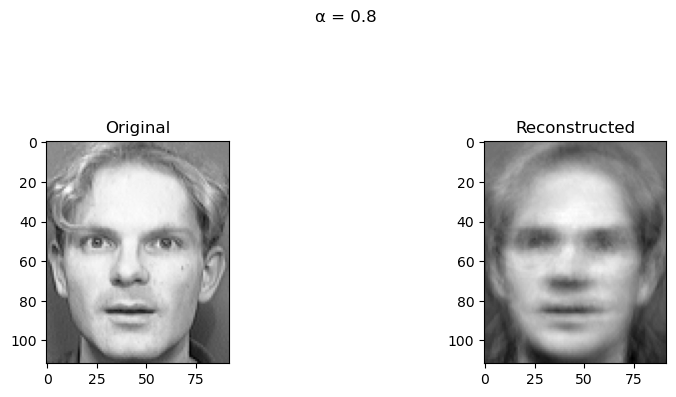

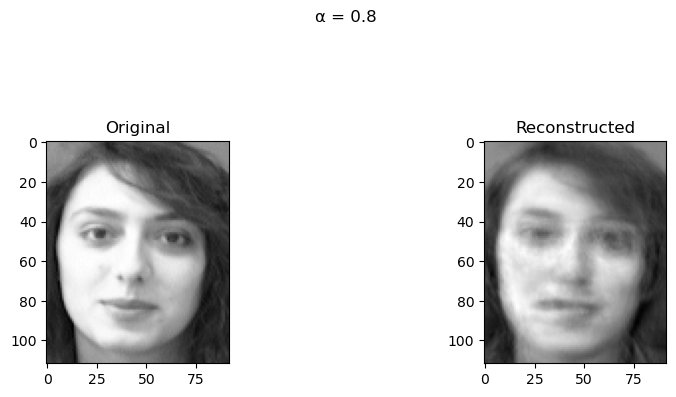

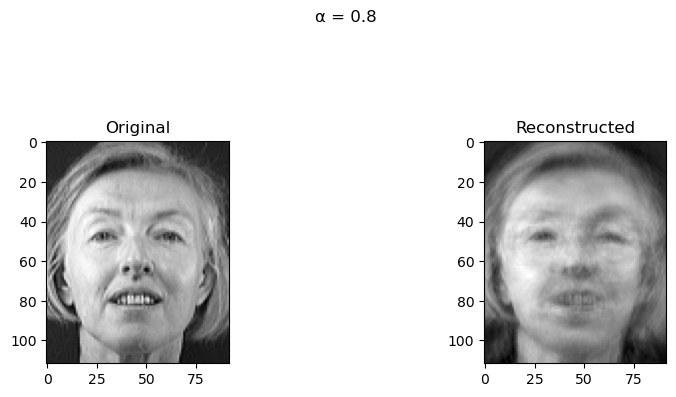

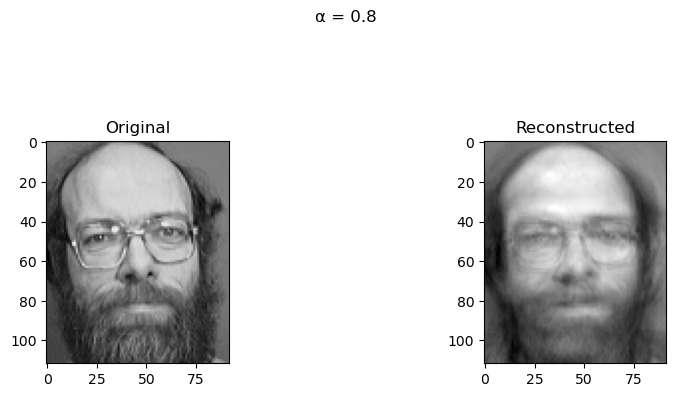

Retained dimensions: 68 (out of 10304)


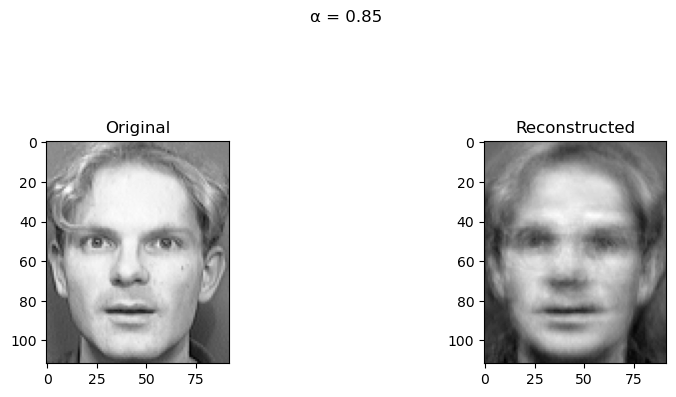

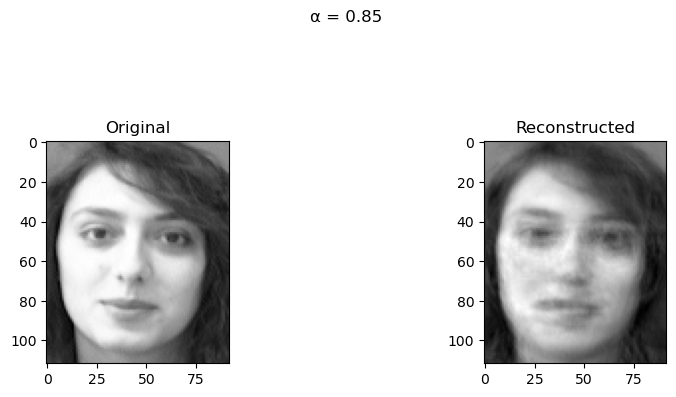

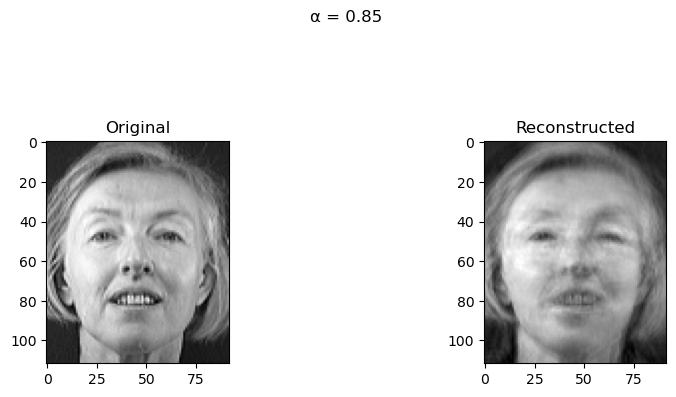

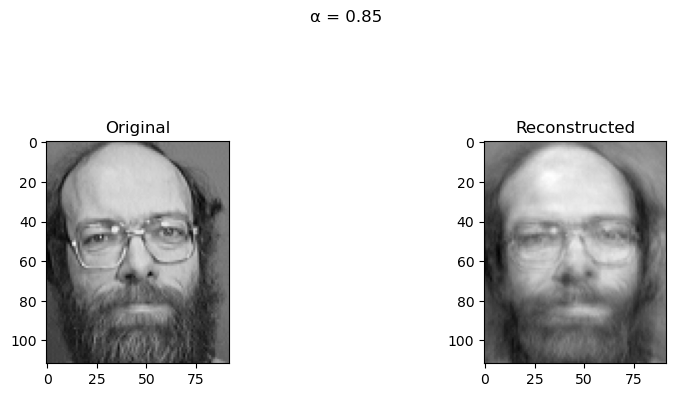

Retained dimensions: 111 (out of 10304)


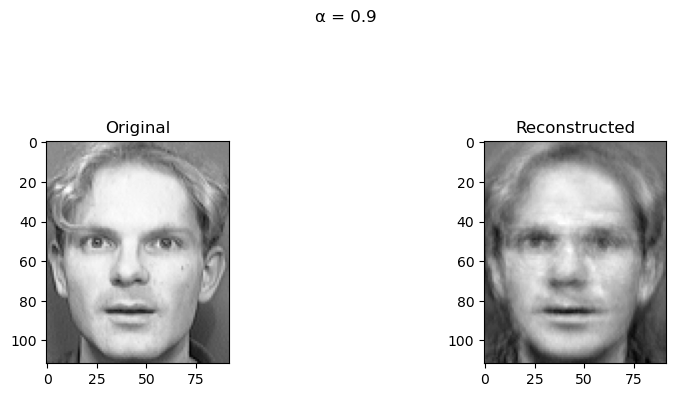

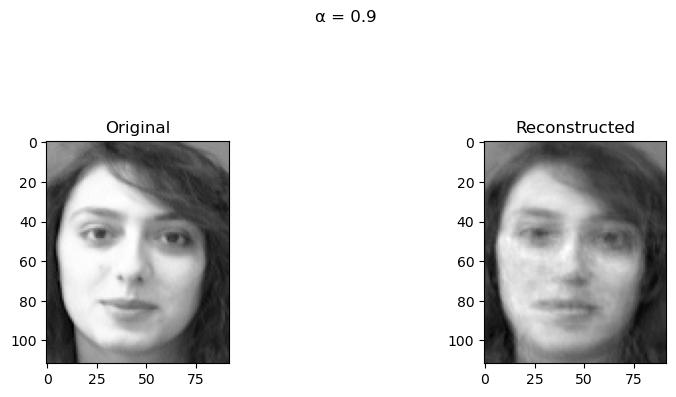

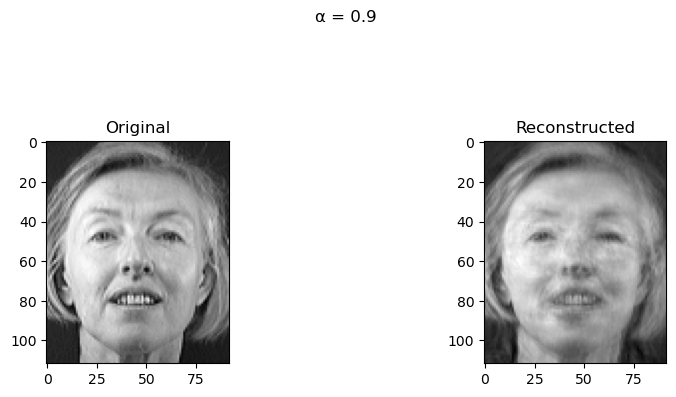

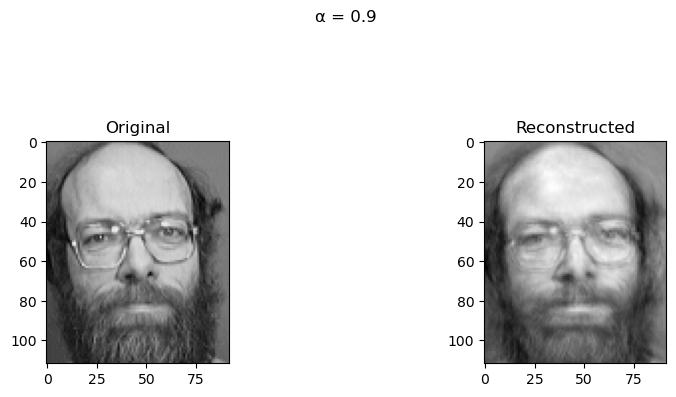

Retained dimensions: 190 (out of 10304)


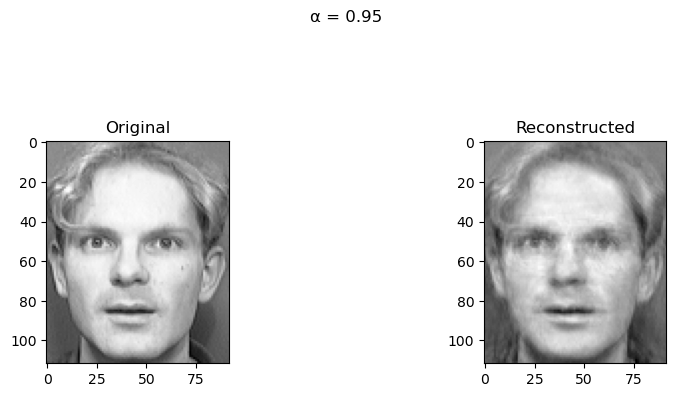

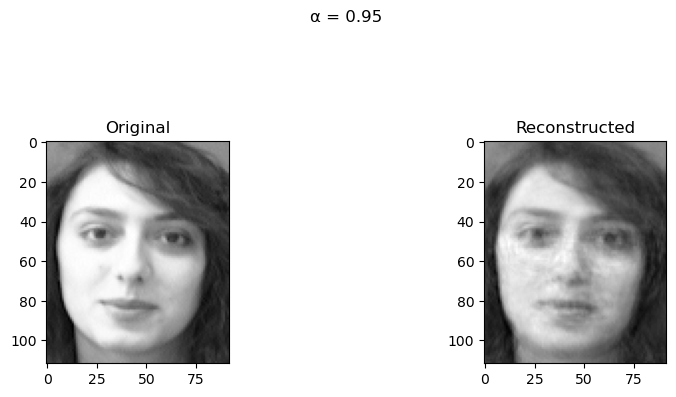

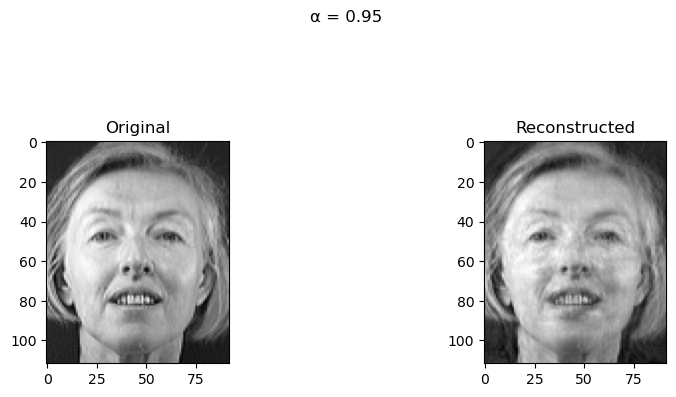

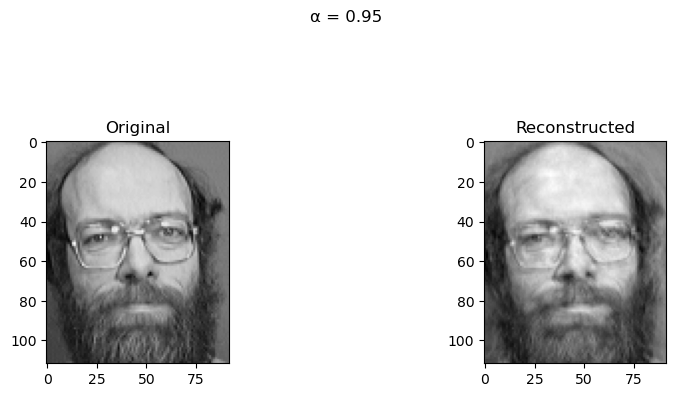

In [ ]:
num_faces = features.shape[0]
random_indices = np.random.choice(num_faces, size=4, replace=False)
random_faces = features[random_indices]


for alpha in alphas:
    pca = PCA(alpha=alpha)
    pca.load_eigen(alpha)
    Z = pca.transform(X)
    # Report dimensionality
    print(f"Retained dimensions: {pca.k} (out of {X.shape[1]})")
    
    # Visualize few transformed vectors
    for i in random_indices:  # visualize 3 random faces
        plt.figure(figsize=(8, 5))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(X[i].reshape(112, 92), cmap='gray')  
        plt.title("Original")

        # Reconstructed image
        X_rec = pca.inverse_transform(Z[i])
        plt.subplot(1, 3, 3)
        plt.imshow(X_rec.reshape(112, 92), cmap='gray')
        plt.title("Reconstructed")
        
        plt.suptitle(f"α = {alpha}")
        plt.show()

## K-means Clustering
- K-Means was applied on PCA-reduced data with different K values: 20, 40, 60.
- Centroids initialized from random training samples.
- Stopping criteria: convergence based on centroid movement or max iterations.
- Majority voting was used to assign cluster IDs to true class labels

In [28]:
import numpy as np
from scipy.stats import mode
from collections import Counter
import matplotlib.pyplot as plt

# --- K-Means Functions (modular) ---
def initialize_centroids(X, K):
    indices = np.random.choice(X.shape[0], K, replace=False)
    return X[indices]


def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2) # Compute distances to centroids L2 norm (Euclidean distance)
    clustring =np.argmin(distances, axis=1)
    
    return clustring

def update_centroids(X, labels, K):
    new_centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        cluster_points = X[labels == k]
        if len(cluster_points) > 0:
            new_centroids[k] = np.mean(cluster_points, axis=0)
    return new_centroids

def kmeans(X, K, max_iters=300, tol=1e-4):
   
    for attempt in range(100):  # Try multiple times to get valid clustering
        centroids = initialize_centroids(X, K)
        for _ in range(max_iters):
            labels = assign_clusters(X, centroids)
            
            # Check if all clusters have at least one sample
            unique_labels = np.unique(labels)
            if len(unique_labels) < K:
                print(" Empty cluster detected. Reinitializing centroids...")
                break  # Restart with new centroids

            new_centroids = update_centroids(X, labels, K)

            if np.allclose(centroids, new_centroids, atol=tol):
                print(f"Attempt {attempt + 1}: K-Means converged with {len(unique_labels)} clusters.")
                return labels, new_centroids  # Converged and valid

            centroids = new_centroids
        

    raise ValueError("K-Means failed to assign all clusters even after multiple attempts.")

# --- Clustering Accuracy Function ---
def calculate_clustering_accuracy(true_labels, cluster_labels, num_classes):
    new_labels = np.zeros_like(cluster_labels)
    for i in range(num_classes):
        mask = cluster_labels == i
        if np.any(mask):
            new_labels[mask] = mode(true_labels[mask])[0]

    accuracy = np.mean(new_labels == true_labels)
    return accuracy



def majority_vote_label_mapping(true_labels, cluster_labels,k):
    """
    Maps each cluster index to the most frequent true label using majority voting.
    Returns the mapped predicted labels and the mapping dictionary.
    """
    mapping = {}
    new_labels = np.zeros_like(cluster_labels)

    for cluster_id in range(k):
        # Find the true labels of samples in this cluster
        indices = np.where(cluster_labels == cluster_id)[0] # Get indices of samples in this cluster
        true_labels_in_cluster = true_labels[indices] # Get true labels of samples in this cluster

        # If no true labels in this cluster, skip
        # This can happen if a cluster is empty it happens in rare cases where In rare cases (especially with bad centroid initialization or too many clusters, e.g., K > actual groups), some clusters may never get assigned any points.
        if len(true_labels_in_cluster) == 0: 
            continue

        # Count the frequency of each true label
        most_common_label = Counter(true_labels_in_cluster).most_common(1)[0][0]

        # Save the mapping
        mapping[cluster_id] = most_common_label

        # Assign the mapped label to all points in the cluster
        new_labels[indices] = most_common_label
        
    return new_labels, mapping


    

In [29]:
def plot_accuracy_vs_K(results, alphas, Ks):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))
    for alpha in alphas:
        accuracies = [results[alpha][K] for K in Ks]
        plt.plot(Ks, accuracies, marker='o', label=f'α = {alpha}')

    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Clustering Accuracy")
    plt.title("Accuracy vs K (for each Alpha)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_accuracy_vs_alpha(results, alphas, Ks):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))
    for K in Ks:
        accuracies = [results[alpha][K] for alpha in alphas]
        plt.plot(alphas, accuracies, marker='o', label=f'K = {K}')

    plt.xlabel("Alpha (Variance Retained)")
    plt.ylabel("Clustering Accuracy")
    plt.title("Accuracy vs Alpha (for each K)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



--- K-Means Clustering Results ---


Alpha (α) = 0.80
-----------------------------------
K          Clustering Accuracy
-----------------------------------
Attempt 1: K-Means converged with 20 clusters.
20                      0.4550
Attempt 1: K-Means converged with 40 clusters.
40                      0.7300
Attempt 1: K-Means converged with 60 clusters.
60                      0.7800

Alpha (α) = 0.85
-----------------------------------
K          Clustering Accuracy
-----------------------------------
Attempt 1: K-Means converged with 20 clusters.
20                      0.4250
Attempt 1: K-Means converged with 40 clusters.
40                      0.6450
Attempt 1: K-Means converged with 60 clusters.
60                      0.7950

Alpha (α) = 0.90
-----------------------------------
K          Clustering Accuracy
-----------------------------------
Attempt 1: K-Means converged with 20 clusters.
20                      0.4100
Attempt 1: K-Means converged with 40 clusters.
40     

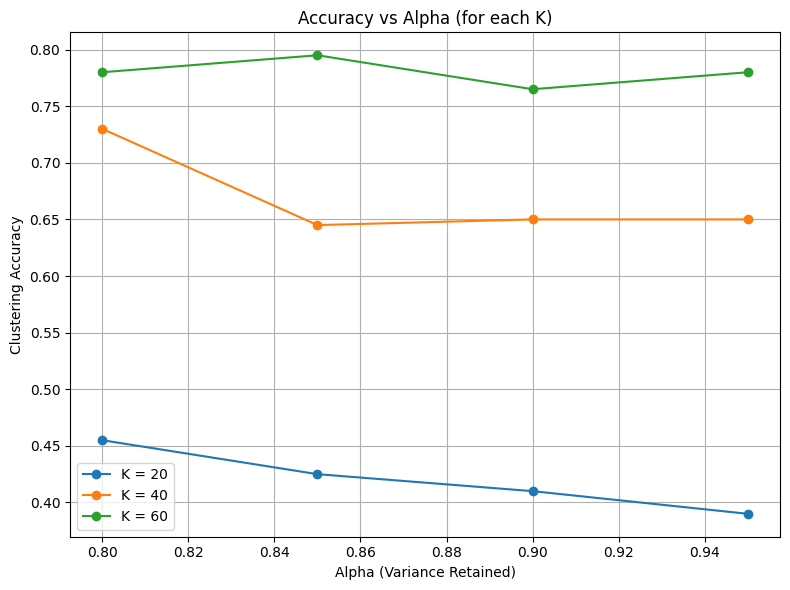

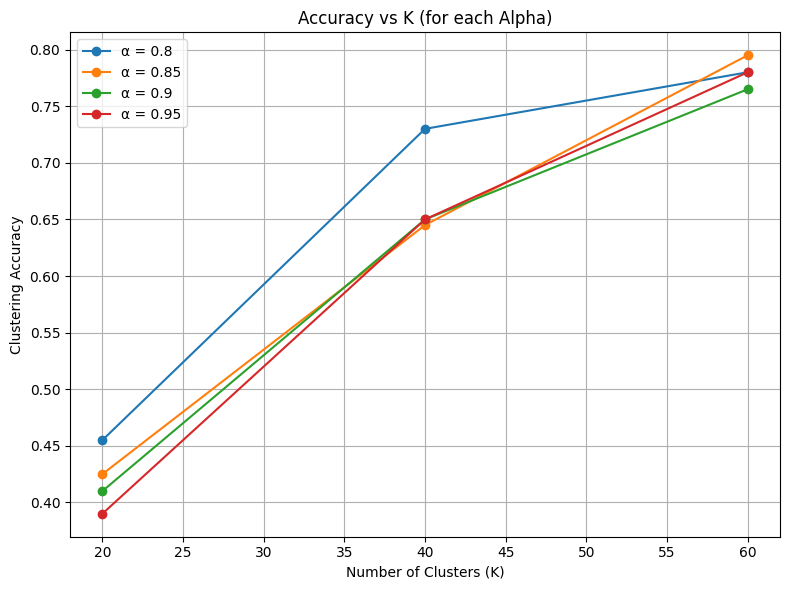

In [30]:

# --- MAIN PROCESSING AFTER YOUR FEATURE EXTRACTION ---
def Kmeans_Clustering(alphas, Ks):
    pca = PCA()
    pca.load_eigen("train")
    results = {}
    
    best_acc = -1
    best_model = {
        'alpha': None,
        'K': None,
        'centroids': None,
        'mapping': None,
        'labels': None
    }
    print("\n--- K-Means Clustering Results ---\n")

    for alpha in alphas:
        results[alpha] = {}
        
        pca.set_alpha(alpha)
        reduced_features = pca.transform(X_train)

        print(f"\nAlpha (α) = {alpha:.2f}")
        print("-" * 35)
        print(f"{'K':<10}{'Clustering Accuracy':>20}")
        print("-" * 35)

        for K in Ks:
            cluster_labels, centroids = kmeans(reduced_features, K)
            mapped_labels, mapping = majority_vote_label_mapping(y_train, cluster_labels, K)
            acc = np.mean(mapped_labels == y_train)
            results[alpha][K] = acc

            print(f"{K:<10}{acc:>20.4f}")
            
            # Update best model if this one is better
            if acc > best_acc:
                best_acc = acc
                best_model['alpha'] = alpha
                best_model['K'] = K
                best_model['centroids'] = centroids
                best_model['mapping'] = mapping
                best_model['labels'] = mapped_labels

    print("\n Clustering completed for all alpha and K values.")
    print(f"\n Best model: α = {best_model['alpha']}, K = {best_model['K']}, Accuracy = {best_acc:.4f}")

    
    return best_model,results
    


alphas = [0.8, 0.85, 0.9, 0.95]
Ks = [20,40,60]
best_model,results = Kmeans_Clustering(alphas, Ks)
plot_accuracy_vs_alpha(results, alphas, Ks)
plot_accuracy_vs_K(results, alphas, Ks)



Small K → not enough clusters → low accuracy.

Medium K (like 40) → good balance → peak accuracy.

Too large K (like 60) → overfitting → accuracy drops.

Lower 
𝛼
α keeps fewer principal components, which may remove noise and redundant information.

Higher 
𝛼
α retains more dimensions, possibly including noise → harder clustering.
When alpha is very high (0.95), PCA keeps more small details (noise), which may confuse clustering.

Keeping less unnecessary detail (like at alpha=0.8) makes clustering easier — the faces are represented in a cleaner, simpler way.


✅ Evaluation on Test Set:
Accuracy: 0.7100
F1-Score (macro): 0.6707


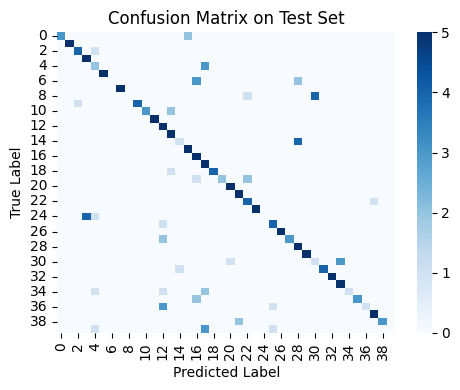

(0.71,
 0.6707359633830222,
 array([[3, 0, 0, ..., 0, 0, 0],
        [0, 5, 0, ..., 0, 0, 0],
        [0, 0, 4, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 5, 0, 0],
        [0, 0, 0, ..., 0, 3, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64))

In [39]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_kmeans_on_test(best_model, X_test, y_test, pca):
    """
    Evaluate the best K-Means model on the test set using Accuracy, F1-Score, and Confusion Matrix.

    Args:
        best_model (dict): Contains centroids, mapping, alpha, and K.
        X_test (np.ndarray): Test set features (before PCA).
        y_test (np.ndarray): Test set true labels.
        pca (object): PCA object with transform method.
    """

    #Apply PCA on X_test
    pca = PCA()
    pca.load_eigen("train")
    pca.set_alpha(best_model['alpha'])
    X_test_pca = pca.transform(X_test)

    #Predict clusters for test samples using the best model centroids
    centroids = best_model['centroids']
    distances = np.linalg.norm(X_test_pca[:, np.newaxis] - centroids, axis=2)
    test_cluster_labels = np.argmin(distances, axis=1)

    # Map cluster labels to subject IDs
    mapping = best_model['mapping']
    #For each predicted cluster_id in the test set,
    #Retrieve the corresponding subject ID that was assigned by majority vote during training as it is evaltion part
    y_pred = np.array([mapping.get(c, -1) for c in test_cluster_labels])
    
    
    # 4. Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    confusionM = confusion_matrix(y_test, y_pred)

    # 5. Display nicely
    print("\n✅ Evaluation on Test Set:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score (macro): {f1:.4f}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(confusionM, annot=False, cmap="Blues", fmt="d", cbar=True)
    plt.title('Confusion Matrix on Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    return acc, f1, confusionM

# Evaluate the best K-Means model on the test set
evaluate_kmeans_on_test(best_model, X_test, y_test, pca)





## Bonus: Design an autoencouder NN

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(10304, 5152),
            nn.ReLU(),
            nn.Linear(5152, 2576),
        )
        
        # Decoder 
        self.decoder = nn.Sequential(
            nn.Linear(2576, 5152),
            nn.ReLU(),
            nn.Linear(5152, 10304),
            nn.Sigmoid()        
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [34]:
def train(lr= 0.0005, epochs = 100,features = None):
    features = features.astype(np.float32) 
    features /= 255.0
    
    # Convert features to a Tensor
    features_tensor = torch.from_numpy(features)
    dataset = TensorDataset(features_tensor)

    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    model = AutoEncoder(input_size=10304)  # Make sure to pass input size if needed
    
    Loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in dataloader:
            inputs = batch[0].to(device)
            
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = Loss(outputs, inputs)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

    return model    

In [ ]:
model = train(epochs = 200,features= features)

Epoch [1/50], Loss: 0.041437
Epoch [2/50], Loss: 0.038112
Epoch [3/50], Loss: 0.029571
Epoch [4/50], Loss: 0.025772
Epoch [5/50], Loss: 0.025055
Epoch [6/50], Loss: 0.024829
Epoch [7/50], Loss: 0.025431
Epoch [8/50], Loss: 0.023714
Epoch [9/50], Loss: 0.024535
Epoch [10/50], Loss: 0.024024
Epoch [11/50], Loss: 0.024275
Epoch [12/50], Loss: 0.024461
Epoch [13/50], Loss: 0.024796
Epoch [14/50], Loss: 0.024784
Epoch [15/50], Loss: 0.023693
Epoch [16/50], Loss: 0.024085
Epoch [17/50], Loss: 0.023839
Epoch [18/50], Loss: 0.023049
Epoch [19/50], Loss: 0.022122
Epoch [20/50], Loss: 0.023375
Epoch [21/50], Loss: 0.022618
Epoch [22/50], Loss: 0.023248
Epoch [23/50], Loss: 0.022831
Epoch [24/50], Loss: 0.022802
Epoch [25/50], Loss: 0.022698
Epoch [26/50], Loss: 0.022372
Epoch [27/50], Loss: 0.022693
Epoch [28/50], Loss: 0.022708
Epoch [29/50], Loss: 0.023546
Epoch [30/50], Loss: 0.023021
Epoch [31/50], Loss: 0.022482
Epoch [32/50], Loss: 0.022877
Epoch [33/50], Loss: 0.022387
Epoch [34/50], Loss

In [28]:
# store pickle file
import pickle
with open('autoencoder_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### Use autoencoder to reduce dimensionality of the dataset

In [17]:
def autoencoder_reduce(model, X):
    model.eval()
    X_tensor = torch.from_numpy(X)
    with torch.no_grad():
        encoded_representations = model.encoder(X_tensor)  
    return encoded_representations

### Reconstruct Images using autoencoder network

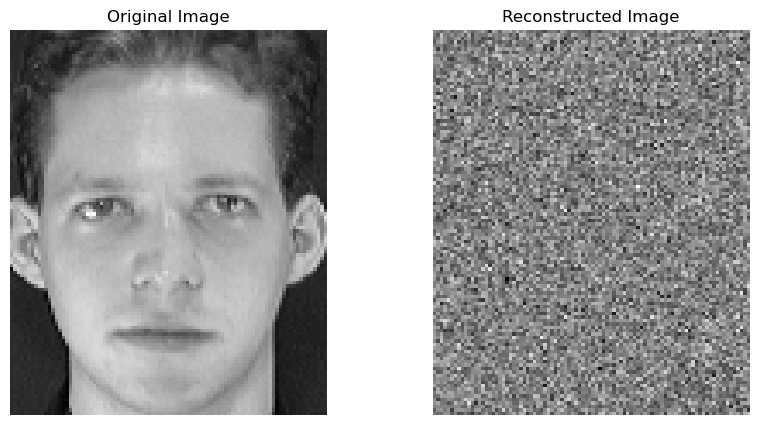

In [ ]:

model = AutoEncoder(input_size=10304).to(device)

sample_idx = 0
sample_image = features[sample_idx]  # shape (10304,)
sample_image_tensor = torch.from_numpy(sample_image).float().to(device)

model.eval()
with torch.no_grad():
    input_tensor = sample_image_tensor.unsqueeze(0)  
    
    reconstructed_tensor = model(input_tensor)  
    
    reconstructed_image = reconstructed_tensor.squeeze(0).cpu().numpy()

original_image = sample_image.reshape(112, 92)
reconstructed_image = reconstructed_image.reshape(112, 92)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')

plt.show()

In [28]:
print(Z)

[[ 1429.86234363  1193.58697313 -2013.4661952  ...    -4.9446789
   -105.52757595   -82.46844534]
 [ 2963.04592996  1162.0483341    146.90398565 ...   -95.66533482
    -18.64531324   -91.5803923 ]
 [ 3152.29950972  1467.20016435  -417.78973193 ...   -92.33497522
    -80.55097579   -34.22119357]
 ...
 [ -958.13202037  1223.43385881   349.9111249  ...   -53.71844504
     70.81520085   -19.43775976]
 [-1001.8326715   1109.3318066    679.12012836 ...  -182.27916443
    148.04596955   170.21352454]
 [ -884.83951376  1582.04813205   575.95258289 ...    10.98094237
    174.19746881  -174.80966181]]


# Gaussian Mixture Model (GMM)
Gaussian Mixture Model (GMM) is a probabilistic model that assumes the data is generated from a mixture of several Gaussian distributions.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns


- **Mixture Model**: GMM models the overall distribution as a weighted sum of `K` Gaussian distributions.
- **Soft Clustering**: Each data point is assigned a probability of belonging to each cluster, rather than a single label.



## Components of GMM
 GMM defines:
- **Mean** : Center of the Gaussian.
- **Covariance** : Shape and spread of the Gaussian.
- **Mixing coefficient** : Prior probability of selecting component k, with sum of responsibilities = 1.



## The EM Algorithm

GMM uses the **Expectation-Maximization (EM)** algorithm to estimate parameters from data:

### 1. Initialization
- Randomly initialize the means, covariances
- Normally initialize the mixing coefficients pi_k such that sum pi_k = 1 .

### 2. E-step (Expectation)
- Compute the **responsibility** for each data point and component k , which is the probability that x_i  was generated by component  k .
![image](Snapshots\responsibilities.png)
### 3. M-step (Maximization)
- Update the parameters using current responsibilities:
![image](Snapshots\eqns.png)

### 4. Check Log-Likelihood
- Compute total log-likelihood of the data.
- If the improvement is below a threshold, stop; otherwise, repeat the steps.



In [19]:
class GMM:
    def __init__(self, K, max_iter=500, tol=1e-10):
        self.K = K
        self.max_iter = max_iter
        self.tol = tol
        self.pi = np.ones(self.K) / self.K
        self.responsibilities = None
        self.means = None
        self.covariances = None

    def _e_step(self, X):
        n_samples, _ = X.shape
        log_resp = np.zeros((n_samples, self.K))

        for i in range(self.K):
            try:
                mvn = multivariate_normal(mean=self.means[i], cov=self.covariances[i], allow_singular=True)
                log_resp[:, i] = np.log(np.clip(self.pi[i], 1e-10, 1.0)) + mvn.logpdf(X)
            except:
                log_resp[:, i] = -1e10  # fallback in case of numerical issues

        # Log-sum-exp trick
        max_log = np.max(log_resp, axis=1, keepdims=True)
        log_sum = max_log + np.log(np.sum(np.exp(log_resp - max_log), axis=1, keepdims=True))
        self.responsibilities = np.exp(log_resp - log_sum)

    def _m_step(self, X):
        n_samples, n_features = X.shape
        sigma_R = np.sum(self.responsibilities, axis=0)
        sigma_R[sigma_R == 0] = 1e-6  # prevent divide by zero

        self.means = (self.responsibilities.T @ X) / sigma_R[:, np.newaxis]

        self.covariances = np.zeros((self.K, n_features, n_features))
        for i in range(self.K):
            diff = X - self.means[i]
            weighted_diff = diff.T * self.responsibilities[:, i]
            cov = weighted_diff @ diff / sigma_R[i]
            self.covariances[i] = cov + np.eye(n_features) * 1e-3  # Regularize 
        self.pi = sigma_R / n_samples

    def _compute_log_likelihood(self, X):
        n_samples = X.shape[0]
        log_prob = np.zeros((n_samples, self.K))

        for i in range(self.K):
            try:
                mvn = multivariate_normal(mean=self.means[i], cov=self.covariances[i], allow_singular=True)
                log_prob[:, i] = np.log(np.clip(self.pi[i], 1e-10, 1.0)) + mvn.logpdf(X)
            except:
                log_prob[:, i] = -1e10

        max_log = np.max(log_prob, axis=1, keepdims=True)
        log_sum = max_log + np.log(np.sum(np.exp(log_prob - max_log), axis=1, keepdims=True))
        return np.sum(log_sum)

    def fit(self, X):
        n_samples, n_features = X.shape
        rng = np.random.default_rng()
        self.means = X[rng.choice(n_samples, self.K, replace=False)]
        self.covariances = np.array([
            np.cov(X.T) + np.eye(n_features) * 1e-3 for _ in range(self.K)
        ])
        self.pi = np.ones(self.K) / self.K
        prev_log_likelihood = -np.inf

        for iteration in range(self.max_iter):
            self._e_step(X)
            self._m_step(X)
            current_log_likelihood = self._compute_log_likelihood(X)

            # print(f"Iter {iteration + 1}, log-likelihood: {current_log_likelihood:.6f}")

            if np.abs(current_log_likelihood - prev_log_likelihood) < self.tol:
                # print(f"Converged at iteration {iteration + 1}")
                break

            prev_log_likelihood = current_log_likelihood

    def predict(self, X):
        self._e_step(X)
        return np.argmax(self.responsibilities, axis=1)

## Calculating Accuraccies

After training the model, we can calculate the accuracy of the model using the following formula:
we now cluster the data into K-clusters and assign each data point to the cluster with the highest probability(hard assignment). 
Then we can calculate the accuracy of the model using the following criteria:
1. For each cluster, find the most common label among the data points assigned to that cluster.
2. Assign that label to the cluster.
3. Calculate the accuracy as the number of correctly assigned labels divided by the total number of data points.

In [20]:
def gmm_accuracy(gmm_model, X, true_labels, verbose=False):
    """
    Calculate accuracy of GMM clustering after mapping clusters to classes.
    
    Args:
        gmm_model: Trained GMM model
        X: Input features
        true_labels: Ground truth labels
        verbose: Whether to print cluster statistics
        
    Returns:
        tuple: (accuracy, predicted_labels, cluster_to_label_mapping)
    """
    # Get cluster assignments
    cluster_assignments = gmm_model.predict(X)
    
    # Find unique clusters
    unique_clusters = np.unique(cluster_assignments)
    cluster_to_label = {}
    
    # For each cluster, find the majority true label
    for cluster in unique_clusters:
        # Find all samples in this cluster
        cluster_samples = (cluster_assignments == cluster)
        
        # Get their true labels
        cluster_true_labels = true_labels[cluster_samples]
        
        # Find the most common label
        unique_labels, counts = np.unique(cluster_true_labels, return_counts=True)
        majority_label = unique_labels[np.argmax(counts)]
        cluster_to_label[cluster] = majority_label
        
        # Print cluster statistics if verbose
        if verbose:
            print(f"Cluster {cluster}: assigned label {majority_label}, contains {len(cluster_true_labels)} samples")
            print(f"  Label distribution: {dict(zip(unique_labels, counts))}")
    
    # Map each sample's cluster to the assigned label
    predicted_labels = np.array([cluster_to_label[cluster] for cluster in cluster_assignments])
    
    # Calculate accuracy
    accuracy = np.mean(predicted_labels == true_labels)
    
    return accuracy, predicted_labels, cluster_to_label

In [21]:

alpha_values = [0.8, 0.85, 0.9, 0.95]
K_values = [20, 40, 60]

# Store results
results = []
test_results = []
best_accuracy = 0.0
best_alpha = None   
best_K = None
best_model = None
# Loop over alpha and K values
for alpha in alpha_values:
    pca = PCA(alpha=alpha)
    Z = pca.fit_transform(X_train)  # Apply PCA with current alpha
    
    for K in K_values:
        print(f"\n--- Testing Alpha={alpha}, K={K} ---")
        GMM_model = GMM(K=K)
        GMM_model.fit(Z)  # Fit GMM with current K
        
        # Compute clustering accuracy
        accuracy, predicted_labels, cluster_mapping = gmm_accuracy(GMM_model, Z, y_train)
        results.append((alpha, K, accuracy))
        print(f"Alpha: {alpha}, K: {K}, Train Accuracy: {accuracy * 100:.2f}%")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = alpha
            best_K = K
            best_model = GMM_model

print(f"Best Model: Alpha={best_alpha}, K={best_K}, Accuracy={best_accuracy * 100:.2f}%")



--- Testing Alpha=0.8, K=20 ---
Alpha: 0.8, K: 20, Train Accuracy: 37.00%

--- Testing Alpha=0.8, K=40 ---
Alpha: 0.8, K: 40, Train Accuracy: 55.50%

--- Testing Alpha=0.8, K=60 ---
Alpha: 0.8, K: 60, Train Accuracy: 69.00%

--- Testing Alpha=0.85, K=20 ---
Alpha: 0.85, K: 20, Train Accuracy: 34.50%

--- Testing Alpha=0.85, K=40 ---
Alpha: 0.85, K: 40, Train Accuracy: 51.50%

--- Testing Alpha=0.85, K=60 ---
Alpha: 0.85, K: 60, Train Accuracy: 69.50%

--- Testing Alpha=0.9, K=20 ---
Alpha: 0.9, K: 20, Train Accuracy: 26.00%

--- Testing Alpha=0.9, K=40 ---
Alpha: 0.9, K: 40, Train Accuracy: 47.00%

--- Testing Alpha=0.9, K=60 ---
Alpha: 0.9, K: 60, Train Accuracy: 59.50%

--- Testing Alpha=0.95, K=20 ---
Alpha: 0.95, K: 20, Train Accuracy: 20.50%

--- Testing Alpha=0.95, K=40 ---
Alpha: 0.95, K: 40, Train Accuracy: 38.00%

--- Testing Alpha=0.95, K=60 ---
Alpha: 0.95, K: 60, Train Accuracy: 51.00%
Best Model: Alpha=0.85, K=60, Accuracy=69.50%


Best Model: Alpha=0.85, K=60, Accuracy=69.50%


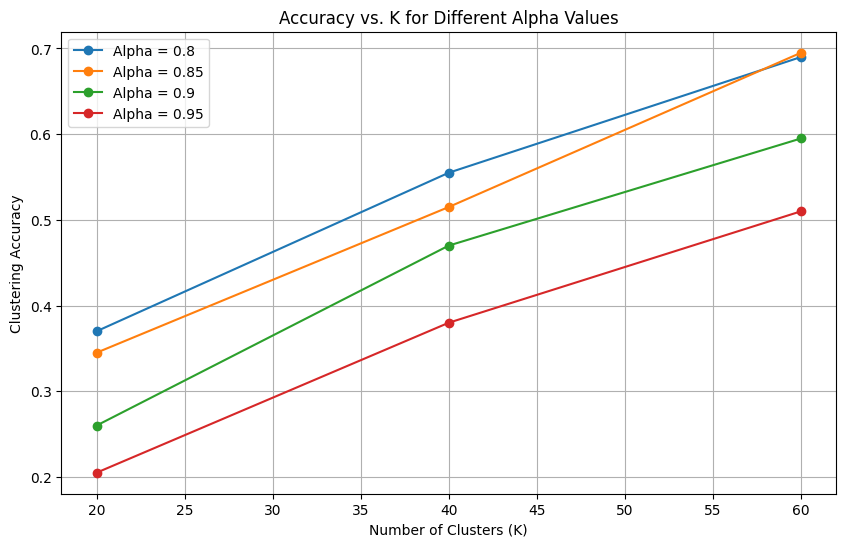

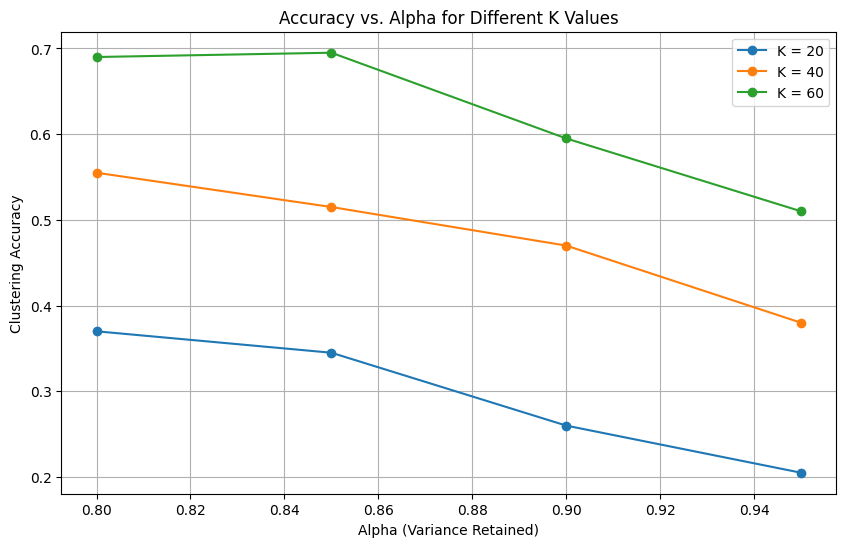

In [22]:
print(f"Best Model: Alpha={best_alpha}, K={best_K}, Accuracy={best_accuracy * 100:.2f}%")

# Convert results to a structured array for easier plotting
results = np.array(results, dtype=[('alpha', float), ('K', int), ('accuracy', float)])

# Plot Accuracy vs. K for each alpha
plt.figure(figsize=(10, 6))
for alpha in alpha_values:
    subset = results[results['alpha'] == alpha]
    plt.plot(subset['K'], subset['accuracy'], marker='o', label=f'Alpha = {alpha}')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Clustering Accuracy')
plt.title('Accuracy vs. K for Different Alpha Values')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy vs. Alpha for each K
plt.figure(figsize=(10, 6))
for K in K_values:
    subset = results[results['K'] == K]
    plt.plot(subset['alpha'], subset['accuracy'], marker='o', label=f'K = {K}')
plt.xlabel('Alpha (Variance Retained)')
plt.ylabel('Clustering Accuracy')
plt.title('Accuracy vs. Alpha for Different K Values')
plt.legend()
plt.grid()
plt.show()

## Test the model on the test set and calculate the accuracy, Confusion matrix and F-1 score.

Alpha = 0.85, K = 60, Test Accuracy: 24.00%


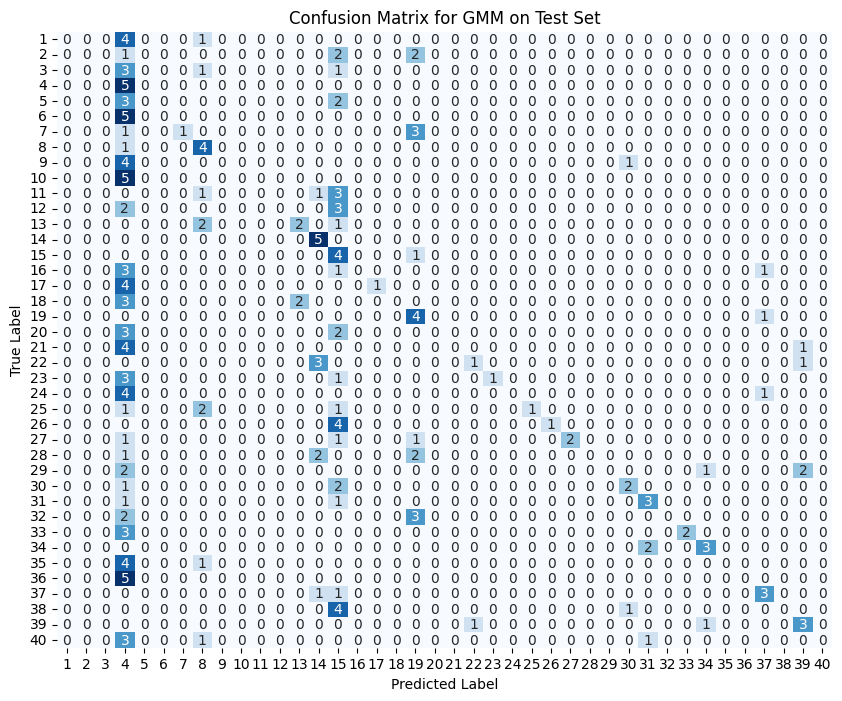

F1 Score: 0.20


In [23]:
#Test the best model on the test set
pca = PCA(alpha=best_alpha)  
Z_test = pca.fit_transform(X_test)  
test_accuracy, test_predicted_labels, test_cluster_mapping = gmm_accuracy(best_model, Z_test, y_test, verbose=False)

print(f"Alpha = {best_alpha}, K = {best_K}, Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot confusion matrix for test set
cm = confusion_matrix(y_test, test_predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for GMM on Test Set')
plt.show()

#compute F-1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, test_predicted_labels, average='macro')  # equal weight to all classes
print(f"F1 Score: {f1:.2f}")



## F1 Score
F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

![image](Snapshots\f1.png)

**macro**: Unweighted mean of F1 across all classes.